Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

In [7]:

def lane(posx):
    ts = [90, 100, 150]
    rate = 8.0
    height = 10.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0])  + (posx - ts[0])/10.0, 1.0/10.0
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)) + (ts[1] - ts[0])/10.0, np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))

'''

def nominal(posx):
    ts = [80, 90, 150]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))


def lane(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((ts[3] - posx)/(2 * rate)))
    
def nominal(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((posx - ts[3])/(2 * rate)))
'''

def barrier_u(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
                                                                      
def barrier_l(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return - 1 + posx, -3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return - 1 + posx, -3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return - 1 + posx, -3 + lane(posx)[0], lane(posx)[1]
    
def nominal(posx):
    return barrier_u(posx)[1] * 0.5 + barrier_l(posx)[1] * 0.5, (barrier_u(posx)[2] + barrier_l(posx)[2]) * 0.5

  

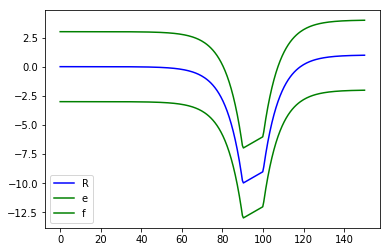

In [8]:
posx_path = np.linspace(0, 150, 300)
x_nominal = [[posx_path[i], nominal(posx_path[i])[0], 10, nominal(posx_path[i])[1]] for i in range(300)]
x_barrier_u = [[posx_path[i], barrier_u(posx_path[i])[1], 10, barrier_u(posx_path[i])[1]] for i in range(300)]
x_barrier_l = [[posx_path[i], barrier_l(posx_path[i])[1], 10, barrier_l(posx_path[i])[1]] for i in range(300)]
x_lane = [[posx_path[i], lane(posx_path[i])[0], 10, nominal(posx_path[i])[1]] for i in range(300)]

posx_ = np.asarray(x_nominal)[:, 0]
posy_ = np.asarray(x_lane)[:, 1]
posy_u = np.asarray(x_barrier_u)[:, 1]
posy_l = np.asarray(x_barrier_l)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_u, 'g')
_ = plt.plot(posx_, posy_l, 'g')
_ = plt.legend("Reference Path")


In [9]:
n = 2
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 100, checkpoint = 'checkpoints/mlp_H2.pt')

#agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])
#agent.train(num_epoch = 1000)


In [10]:
def agent_run(agent, x0s):
    agent_traj = []
    for x0 in x0s:
        agent_traj.append([])
        for _ in range(0, N):
            i = abs(int(x0[0]/0.5))
            x_nn = []
            if i >= N - H - 1:
                break
            x_nominal_ = x_nominal[i: i + H]
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            agent_traj[-1] = agent_traj[-1] + [[x0[:], u[0]]]
            x1 = dynamics.f(x0, u[0], i)[0]        
            x0 = x1[:]
    return agent_traj

x0s = []
batch_size = 20
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj = agent_run(agent, x0s)
        

print("Done")

/home/depend/virtualenv_py3/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/depend/virtualenv_py3/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Done


The red curve in the plot shows the trajectory of the regression model controller.

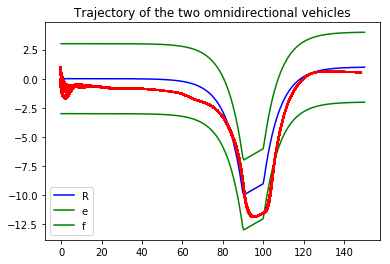

In [11]:
def draw_agent_traj(agent_trajs):
    plt.title("Trajectory of the two omnidirectional vehicles")
    plt.legend(["Vehicle", "Reference Path"])
    
    posx_ = np.asarray(x_nominal)[:, 0]
    posy_ = np.asarray(x_lane)[:, 1]
    posy_u = np.asarray(x_barrier_u)[:, 1]
    posy_l = np.asarray(x_barrier_l)[:, 1]
    _ = plt.plot(posx_, posy_, "b")
    _ = plt.plot(posx_, posy_u, 'g')
    _ = plt.plot(posx_, posy_l, 'g')
    _ = plt.legend("Reference Path")

    posx = []
    posy = []
    v = []
    theta = []
    for agent_traj in agent_trajs:
        posx.append([])
        posy.append([])
        v.append([])
        theta.append([])
        for j in agent_traj:
            posx[-1].append(j[0][0])
            posy[-1].append(j[0][1])
            v[-1].append(j[0][2])
            theta[-1].append(j[0][3])
            plt.plot(posx[-1], posy[-1], "r")

    plt.show()

draw_agent_traj(agent_traj)

In [14]:
N = len(x_nominal)
H = 2  # Number of time steps in trajectory.
n = 20
n_init = 0
#n_end = 250
n_end = N - H - 1

# Initial state.
x0s = [[x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
              x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
              x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
              x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)] for i in range(1)]

# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []

# Instantenous state cost.
Q = 0.0 * np.eye(dynamics.state_size)
Q[3, 3] = 0.0
Q[1, 1] = 0.0

R = np.eye(dynamics.action_size)
R[0, 0] = 0.0
R[1, 1] = 0.0


q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1., 0, 0]], [[0, -1., 0, 0]]])
b = np.array([[-0.0], [0.0]])
q1 = [150.0, 10.0]
q2 = [150.0, 10.0]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])

def MPSC(agent, x0s):
    train_traj = []
    nn_traj = []
    mpc_traj= []
    traj = []
    for num in range(len(x0s)):
        train_traj.append([])
        nn_traj.append([])
        mpc_traj.append([])
        traj.append([])
        x0 = x0s[num]
        for step in range(n_init, n_end):
            print(">>>>>Step {} at {}".format(step, x0))
            i = abs(int(x0[0]/0.5))
            if i > n_end:
                break
            x_nominal_ = x_nominal[i: i + H]
            x_nn = []
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            #print("NN outputs control")
            agent_traj[-1] = agent_traj[-1] + [[x0, u[0, :]]]
            x1 = dynamics.f(x0, u[0], i)[0]
            #print("Get next state")

            if i <= n_end - n - 1:
                n_ilqr =  n 
            elif n_end > i:
                n_ilqr = n_end - i
            else:
                break

            x0_ = x1[:]
            us_ = []
            xs_ = []
            for _ in range(n_ilqr):
                i_ = abs(int(x0_[0]/0.5))
                x_nn_ = []
                for j in [x0_] + x_nominal[i_ : i_ + H]:
                    for k in j:
                        x_nn_.append(k)
                while len(x_nn_) < 4 *(H + 1):
                    for k in x_nominal[-1]:
                        x_nn_.append(k)
                u_ = agent.run([x_nn_])
                xs_.append(x0_[:])
                us_.append(u_[0])
                x1_ = dynamics.f(x0_, u_[0], i_)[0][:]
                x0_ = x1_[:]
            xs_ = np.asarray(xs_)
            us_init = np.asarray(us_[:-1])
            
            if (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[0].T) - b[0,0]\
                           <= 0)).all() == True and \
                (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[1].T) - b[1,0]\
                          <= 0)).all() == True:
                traj[-1].append([x0, u[0, :]])
                nn_traj[-1].append(traj[-1][-1])
                #train_traj[-1].append([x_nn, u[0, :]])
                print("Utilize NN output {}".format(u))
            else: 
                x_nominal_ilqr = x_nominal[i + 1: i + 1 + n_ilqr]
                #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))


                cost_ = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:], \
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
                try:
                    xs, us = ilqr_.fit(x1, us_init, on_iteration=on_iteration)
                except TypeError as e:
                    print(e)
                    return traj, nn_traj, mpc_traj, train_traj
                us = np.exp(-np.logaddexp(0, -us))
                #print("MPC verifying")


                if (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == True and \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == True:
                    traj[-1].append([x0, u[0, :]])
                    nn_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, u[0, :]])
                    print("Utilize NN output {}".format(u))
                else:
                    max_itr = 50
                    while (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == False or \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == False :

                        if max_itr == 0:
                            return  traj, nn_traj, mpc_traj, train_traj
                        max_itr -= 1    
                        cost = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:],\
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                        ilqr = iLQR(dynamics, cost, n_ilqr - 1)
                        xs, us = ilqr.fit(x0, us_init, n_iterations = (51 - max_itr) * 100, on_iteration=on_iteration)
                        us_init = us[:] + 2 * np.random.random((n - 1, dynamics.action_size)) - 1.0
                        us_init = np.zeros((n - 1, dynamics.action_size))

                        us = np.exp(-np.logaddexp(0, -us))
                    traj[-1].append([x0, us[0]])
                    mpc_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, us[0]])
                    x1 = dynamics.f(x0, us[0], i)[0]
                    print("Utilize MPC output {}".format(us[0]))
                    
            x0 = x1[:]
            
        return  traj, nn_traj, mpc_traj, train_traj
    
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)


>>>>>Step 0 at [0.1091839437331037, -0.1298317111500511, 9.615615948683946, -1.2101076515006983]
Utilize NN output [[0.40149775 0.8629857 ]]
>>>>>Step 1 at [ 0.27902865 -0.58012206  9.63467744 -0.87462229]
Utilize NN output [[0.31978238 0.71691924]]
>>>>>Step 2 at [ 0.58820613 -0.95005377  9.65014294 -0.57835722]
Utilize NN output [[0.39247337 0.5867901 ]]
>>>>>Step 3 at [ 0.99263012 -1.21407107  9.66881747 -0.32379461]
Utilize NN output [[0.2628337  0.45194936]]
>>>>>Step 4 at [ 1.45125344 -1.36798783  9.68166467 -0.11905737]
Utilize NN output [[0.27006564 0.31109208]]
>>>>>Step 5 at [ 1.93223714 -1.4255246   9.69484897  0.02685997]
Utilize NN output [[0.2737486  0.19969454]]
>>>>>Step 6 at [ 2.41713851 -1.41249703  9.70820444  0.12239386]
Utilize NN output [[0.2763082  0.12057153]]
>>>>>Step 7 at [ 2.89925182 -1.35319289  9.72167868  0.18063854]
Utilize NN output [[0.2740385  0.05805143]]
>>>>>Step 8 at [ 3.37775555 -1.2658041   9.73504762  0.20882475]
Utilize NN output [[0.26874414 

Utilize NN output [[ 0.12854128 -0.00256846]]
>>>>>Step 74 at [ 3.65066268e+01 -8.25779308e-01  1.03299759e+01 -5.71639985e-03]
Utilize NN output [[ 0.24533342 -0.00865877]]
>>>>>Step 75 at [ 3.70234178e+01 -8.28733524e-01  1.03420023e+01 -1.01885307e-02]
Utilize NN output [[ 0.23642711 -0.00450704]]
>>>>>Step 76 at [ 3.75407812e+01 -8.34004880e-01  1.03536082e+01 -1.25191066e-02]
Utilize NN output [[ 0.22787234 -0.00193531]]
>>>>>Step 77 at [ 3.80587010e+01 -8.40489112e-01  1.03648086e+01 -1.35209765e-02]
Utilize NN output [[ 0.21965273 -0.00040627]]
>>>>>Step 78 at [ 3.85771643e+01 -8.47499669e-01  1.03756179e+01 -1.37315234e-02]
Utilize NN output [[0.21174899 0.00044429]]
>>>>>Step 79 at [ 3.90961570e+01 -8.54626678e-01  1.03860499e+01 -1.35010366e-02]
Utilize NN output [[0.20414487 0.00085961]]
>>>>>Step 80 at [ 3.96156639e+01 -8.61640985e-01  1.03961177e+01 -1.30546388e-02]
Utilize NN output [[0.19679847 0.00084569]]
>>>>>Step 81 at [ 4.01356683e+01 -8.68429841e-01  1.04058325e+01

Utilize NN output [[ 0.04911748 -0.018308  ]]
>>>>>Step 148 at [75.69690978 -2.50038989 10.77934153 -0.15090446]
Utilize NN output [[ 0.04533214 -0.01664471]]
>>>>>Step 149 at [76.22980776 -2.5814226  10.78160659 -0.15987458]
Utilize NN output [[ 0.04190189 -0.01594585]]
>>>>>Step 150 at [76.76206502 -2.6672495  10.78370045 -0.16846994]
Utilize NN output [[ 0.03877819 -0.01606008]]
>>>>>Step 151 at [77.29366427 -2.75766501 10.78563839 -0.17712855]
Utilize NN output [[ 0.03592215 -0.01684254]]
>>>>>Step 152 at [77.82455261 -2.85269643 10.78743373 -0.18621057]
Utilize NN output [[ 0.03330619 -0.01815791]]
>>>>>Step 153 at [78.354641   -2.95256142 10.78909842 -0.19600336]
Utilize NN output [[ 0.03090516 -0.01988903]]
>>>>>Step 154 at [78.88380473 -3.05762821 10.79064319 -0.20673118]
Utilize NN output [[ 0.02870294 -0.02193996]]
>>>>>Step 155 at [79.41188379 -3.16838091 10.79207794 -0.2185666 ]
Utilize NN output [[ 0.02668471 -0.02423287]]
>>>>>Step 156 at [79.93868266 -3.28539074 10.79341

iteration 0 accepted [-2722.5007299] [105.32014668  -4.31591765  10.93041519   0.91194895] [ 0.8267579  -0.14576516]
Utilize MPC output [0. 1.]
>>>>>Step 199 at [100.10566078 -10.21468326  10.87177015   0.73936419]
iteration 0 accepted [-2766.59977898] [99.45063249 -9.19700928 11.32338438 -1.16578896] [-4.6942353  4.3909674]
Utilize NN output [[ 0.03212837 -0.48899308]]
>>>>>Step 200 at [100.50734644  -9.84837636  10.87337601   0.49289198]
iteration 0 accepted [-2840.3900561] [96.94538559 -8.50141335 10.52511608  2.60343104] [14.376323  -4.6332145]
Utilize NN output [[ 0.03676234 -0.27844802]]
>>>>>Step 201 at [100.98634179  -9.59110381  10.8752133    0.34530325]
iteration 0 accepted [9464.52629356] [97.30815229 -8.43239014 10.52602497  2.03647605] [14.64731   -3.6514926]
Utilize NN output [[ 0.01623487 -0.2354504 ]]
>>>>>Step 202 at [101.49802491  -9.40704372  10.87602497   0.21958911]
iteration 0 failed 7060750.52857469 [110.18258613  -3.12768768  10.90150025   0.54430316] [ 0.017734

Utilize NN output [[0.00762286 0.00046959]]
>>>>>Step 268 at [ 1.34770924e+02  6.10844994e-01  1.09222331e+01 -4.77375097e-03]
Utilize NN output [[0.00698491 0.00191828]]
>>>>>Step 269 at [ 1.35317038e+02  6.08237961e-01  1.09225823e+01 -3.72615921e-03]
Utilize NN output [[0.00640277 0.00275804]]
>>>>>Step 270 at [ 1.35863172e+02  6.06202972e-01  1.09229025e+01 -2.21991626e-03]
Utilize NN output [[0.0058704  0.00312294]]
>>>>>Step 271 at [ 1.36409323e+02  6.04990560e-01  1.09231960e+01 -5.14344521e-04]
Utilize NN output [[0.00538284 0.00312783]]
>>>>>Step 272 at [1.36955489e+02 6.04709642e-01 1.09234651e+01 1.19394243e-03]
Utilize NN output [[0.00493595 0.0028785 ]]
>>>>>Step 273 at [1.37501668e+02 6.05361749e-01 1.09237119e+01 2.76609865e-03]
Utilize NN output [[ 0.01001049 -0.01345086]]
>>>>>Step 274 at [ 1.38047864e+02  6.06872585e-01  1.09242124e+01 -4.58012535e-03]
Utilize NN output [[ 0.00913425 -0.00827703]]
>>>>>Step 275 at [ 1.38594080e+02  6.04370828e-01  1.09246691e+01 -9.10

294


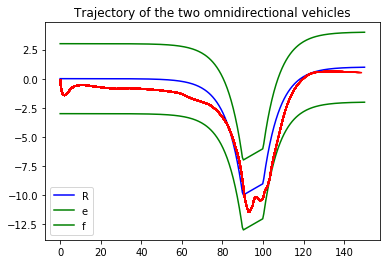

In [15]:
print(len(traj[0]))

draw_agent_traj(traj)
#pickle.dump((traj, nn_traj, mpc_traj, train_traj), open('safe_path_bk1.p', 'wb'))

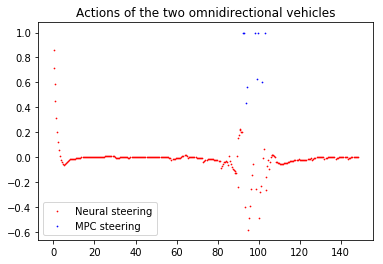

In [16]:
def draw_str(nn_traj, mpc_traj):
    str_nn = []
    posx_nn = []
    str_mpc = []
    posx_mpc = []
    for i in nn_traj[-1]:
        posx_nn.append(i[0][0])
        str_nn.append(i[1][1])
    for j in mpc_traj[-1]:
        posx_mpc.append(j[0][0])
        str_mpc.append(j[1][1])  

    _ = plt.title("Actions of the two omnidirectional vehicles")
    _ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
    _ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
    _ = plt.legend(["Neural steering", "MPC steering"])

draw_str(nn_traj, mpc_traj)

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

In [17]:
def data_to_train(data_trajs):
    train_trajs = []
    for i_traj in range(len(data_trajs)):
        train_trajs.append([])
        for i_xy in range(len(data_trajs[i_traj])):
            train_trajs[i_traj].append([])
            x = data_trajs[i_traj][i_xy][0]
            i = abs(int(x[0]/0.5))
            x_nn = []
            for j in [x] + x_nominal[i : i + H]:
                for k in j:
                    x_nn.append(k)
            while len(x_nn) < 4 *(H + 1):
                for k in x_nominal[-1]:
                    x_nn.append(k)
            u = data_trajs[i_traj][i_xy][1][:]
            train_trajs[i_traj][i_xy] = [x_nn[:], u[:]] 
    return train_trajs

def train_pipeline(agent, x0s, train_trajs = None, paths = None, num_epoch = 100):

    
    #agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 1, checkpoint = 'checkpoints/mlp_H2_995.pt')
    
    X = []
    Y = []
    
    if train_trajs is not None and train_trajs is not []:
        print(len(train_trajs))
        for i_traj in range(len(train_trajs)):
            for i_xy in range(len(train_trajs[i_traj])):
                X.append([x for x in train_trajs[i_traj][i_xy][0]])
                Y.append([y for y in train_trajs[i_traj][i_xy][1]])
    if train_traj is not None or paths is not None:
        agent.data_process(X = X, Y = Y, paths = paths)
        
    n = int(np.asarray(X[0]).shape[0]/dynamics.state_size) - 1
    agent.train(num_epoch = num_epoch)
    #for i in range(len(X)):
    #    print(agent_.run([X[i]]), Y[i])

    agent_temp_traj = agent_run(agent, x0s)    
    draw_agent_traj(agent_temp_traj)
    
    # Random initial action path.
    us_init = np.zeros((n - 1, dynamics.action_size))

    J_hist = []
    q1 = [100.0, 10.0]
    q2 = [100.0, 10.0]

    trajs_, nn_trajs_, mpc_trajs_, train_trajs_ = MPSC(agent, x0s)
    draw_agent_traj(trajs_)
    draw_str(nn_trajs_, mpc_trajs_)
    return trajs_, nn_trajs_, mpc_trajs_, train_trajs_ 



342
2700
[Epoch 1] avg_loss: 0.168
[Epoch 51] avg_loss: 0.164
Finished Training


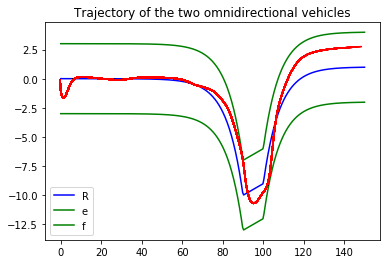

>>>>>Step 0 at [-0.2999364899086613, -0.17488259691580477, 9.74754677570714, -1.3859109565659438]
Utilize NN output [[0.37376744 0.9216605 ]]
>>>>>Step 1 at [-0.21025793 -0.65439272  9.76541091 -1.03174262]
Utilize NN output [[0.3275028 0.8387737]]
>>>>>Step 2 at [ 0.04058605 -1.07376325  9.78122466 -0.69719966]
Utilize NN output [[0.24948436 0.71184427]]
>>>>>Step 3 at [ 0.41575577 -1.38797261  9.79344636 -0.39797634]
Utilize NN output [[0.17156287 0.5992794 ]]
>>>>>Step 4 at [ 0.86735458 -1.5778292   9.80194132 -0.13524921]
Utilize NN output [[0.18747018 0.476635  ]]
>>>>>Step 5 at [ 1.35320548 -1.64394378  9.81120654  0.08213072]
Utilize NN output [[0.2018266  0.36800015]]
>>>>>Step 6 at [ 1.84236029 -1.60367856  9.82116305  0.2549263 ]
Utilize NN output [[0.21444888 0.23841892]]
>>>>>Step 7 at [ 2.31780386 -1.47977984  9.83172409  0.36983479]
Utilize NN output [[0.22228087 0.11956477]]
>>>>>Step 8 at [ 2.77640736 -1.3019916   9.84265864  0.42833269]
Utilize NN output [[0.2268792  0

Utilize NN output [[ 0.19460107 -0.00137632]]
>>>>>Step 111 at [ 5.51681192e+01  4.59532560e-02  1.06571536e+01 -1.84169231e-02]
Utilize NN output [[ 0.186001  -0.0016207]]
>>>>>Step 112 at [ 5.57011163e+01  3.61359788e-02  1.06663479e+01 -1.92805253e-02]
Utilize NN output [[ 0.17796727 -0.0022374 ]]
>>>>>Step 113 at [ 5.62345547e+01  2.58497322e-02  1.06751535e+01 -2.04737667e-02]
Utilize NN output [[ 0.17027156 -0.00270476]]
>>>>>Step 114 at [ 5.67684112e+01  1.49181499e-02  1.06835857e+01 -2.19174471e-02]
Utilize NN output [[ 0.16007823 -0.00483771]]
>>>>>Step 115 at [ 5.73026606e+01  3.20689273e-03  1.06915220e+01 -2.45016294e-02]
Utilize NN output [[ 0.14959046 -0.0067947 ]]
>>>>>Step 116 at [ 5.78372618e+01 -9.89432944e-03  1.06989462e+01 -2.81338567e-02]
Utilize NN output [[ 0.13978006 -0.00794355]]
>>>>>Step 117 at [ 5.83721709e+01 -2.49473584e-02  1.07058900e+01 -3.23831456e-02]
Utilize NN output [[ 0.13063794 -0.00848603]]
>>>>>Step 118 at [ 5.89073471e+01 -4.22841059e-02  1.

Utilize NN output [[ 0.05342444 -0.11160727]]
>>>>>Step 215 at [106.08679902  -3.69219033  11.14469139   0.821735  ]
Utilize NN output [[ 0.06329941 -0.10068095]]
>>>>>Step 216 at [106.46630263  -3.28405378  11.14785214   0.76582089]
Utilize NN output [[ 0.03376213 -0.139505  ]]
>>>>>Step 217 at [106.86810922  -2.89767959  11.14953961   0.68856238]
Utilize NN output [[ 0.03715768 -0.11224481]]
>>>>>Step 218 at [107.29860667  -2.54341374  11.15139664   0.62624995]
Utilize NN output [[ 0.03943266 -0.09002934]]
>>>>>Step 219 at [107.75040703  -2.21658734  11.15336725   0.57618749]
Utilize NN output [[ 0.04076866 -0.07231574]]
>>>>>Step 220 at [108.21808026  -1.91272461  11.15540456   0.53592945]
Utilize NN output [[ 0.04135944 -0.05857819]]
>>>>>Step 221 at [108.6976924   -1.62787822  11.15747135   0.5032936 ]
Utilize NN output [[ 0.04137708 -0.0482721 ]]
>>>>>Step 222 at [109.18643424  -1.35878342  11.15953902   0.47638477]
Utilize NN output [[ 0.04095789 -0.04084444]]
>>>>>Step 223 at [

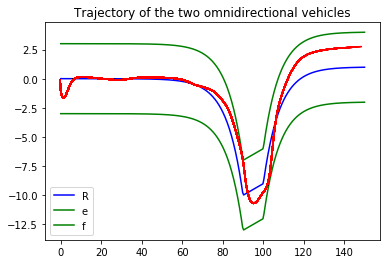

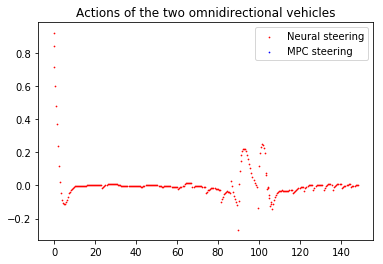

In [579]:
H = 2 
agent_ = NeuralNetwork(input_size = (H + 1) * dynamics.state_size, model_name = 'mlp_temp_H2_temp', batch_size = 500, checkpoint = 'checkpoints/mlp_H2.pt')
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']

train_traj_aggr = 100 * train_traj

trajs_, nn_trajs_, mpc_trajs_, train_trajs_  = train_pipeline(agent_, x0s[:itr_train], train_traj_aggr, paths = None)





#raise TypeError
itr_train = 2
batch_size = 3
'''

'''

while itr_train < batch_size:
    # Initial state.
    agent_ = NeuralNetwork(input_size = (H + 1) * dynamics.state_size, model_name = 'mlp_temp_H2', batch_size = 500, checkpoint = 'checkpoints/mlp_temp_H2.pt')
    train_traj_aggr = train_traj_aggr + int((batch_size - itr_train) * 120 + 1) * train_traj_[:]
    trajs_, nn_trajs_, mpc_trajs_, train_trajs_  = train_pipeline(agent_, x0s[:itr_train], train_traj_aggr, paths = None) 
    itr_train += 1
    
    x0s = [[x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
                  x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
                  x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
                  x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)]]

Done


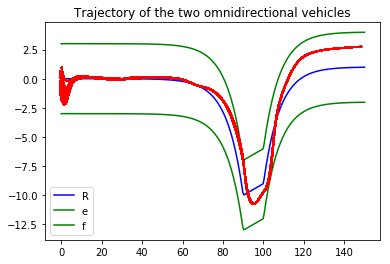

In [580]:
#x0s = []
batch_size = 20
for i_batch in range(batch_size):
    
    x0s.append([x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj_ = agent_run(agent_, x0s)
        

print("Done")
draw_agent_traj(agent_traj_)

<h2>MPSC Guided Policy Search</h2>

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=\pi(x_k; \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& \pi(x_k; \theta)\\
u_k + \delta u_k &=& \pi(x_k + \delta x_k; \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x \pi(x_k; \theta) \delta x_k + \nabla_\theta \pi(x_k; \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.

Previously, we used L-2 norm of the perturbation on the model parameters, i.e. $||\delta \theta||^2_2$, to estimate the loss $L(\delta\theta)$. The optimization problem is as follows.

\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

It is a typical Quadratic Programming problem especially if the constrains are all convex. But it would be extremely computationally expensive for traditional QP solver because the size of $\nabla_\theta \pi(x; \theta)$ can be immensively large. 

Considering the difficulty, we can alternate the problem in the following way.

Firstly, given the current model parameter $\theta_i$, the linearization of the perturbation on the learning model can be rearranged in the following way.

$$\delta \theta_i^T \nabla_\theta \pi(x_k; \theta_i) \approx \delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)$$

Let the optimal control at state $x_k$ be $u^*_k$, which can be presumably obtained with the initial model parametere $\theta_0$, i.e. $u^*_k= \pi(x_k; \theta_0)$. The loss of the model based on this specific data point can be evaluated by using square error  
$$J_{(x_k, u^*_k)}(\theta_i) = ||\pi(x_k; \theta_i) - u^*_k||^2_2$$ 
or log likelihood with fixed covariance $\Sigma$
$$J_{(x_k, u^*_k)}(\theta_i) = -log[\frac{1}{(2\pi)^{\frac{n}{2}}\Sigma} exp\{-\frac{1}{2}[\pi(x_k; \theta_i) - u^*_k]^T \Sigma^{-1}[\pi(x_k,\theta_i)-u^*_k]\}$$

Either way, up to a scale of constant, $\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)= \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]$.

Evaluating the loss of the model based on a set $D=\{\tau = (x_0, u^*_0, \ldots, x_k, u^*_k, \ldots)\}$ of trajectories sampled from the roll-out of the unchanged model, then the increase on the model's loss due to the perturbation is $J_{D}(\theta_i+\delta\theta_i) - J_{D}(\theta_i)\approx \delta\theta_i^T \nabla_\theta J_{D}(\theta_i) + \frac{1}{2}\delta\theta_i^T \nabla^2_\theta J_{D}(\theta_i)\delta\theta_i$ and it is to be minimized.

Using Fisher Information Matrix to replace the second order derivative, the increase of loss turns out to be
\begin{eqnarray}
&&\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T]\delta\theta_i\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} [\delta\theta_i^T\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}[\delta\theta_i^T \nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T\delta\theta_i]\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} \{\delta\theta_i^T\nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]\} + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{\delta\theta_i^T \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T\nabla_\theta \pi(x_k; \theta_i)^T\delta\theta_i\}\\
&\approx& \mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k]\}+ \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)]^T\}\\
&\approx& \frac{1}{4|D|} \sum_{(x_k, u^*_k)\in D} \\
&&\begin{bmatrix} 1\\\delta x_k \\ \delta u_k\end{bmatrix}^T 
\begin{bmatrix} 
0 &-2[\pi(x_k; \theta_i) - u^*_k]^T\nabla_x \pi(x_k; \theta_i)^T &  2[\pi(x_k; \theta_i) - u^*_k]^T\\ 
-2\nabla_x \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \\
2[\pi(x_k; \theta_i) - u^*_k] & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T 
\end{bmatrix} 
\begin{bmatrix}1\\\delta x_k \\ \delta u_k\end{bmatrix} 
\end{eqnarray}

As a result, we get a quadratic objective function of which the variables are only $\delta x$ and $\delta u$. As $\pi(,)$ is considered, variable $\delta\theta$ is implicit in this objective function. After solving the $\delta x$ and $\delta u$, $\delta\theta$ can be directly derived and used to modify $\theta_i$. One thing to be stressed is that $\pi(x_k;\theta_i + \delta\theta_i)\neq u_k + \delta u_k$ because $\delta u_k$ is induced by both $\delta x_k$ and $\delta \theta_i$.

If we choose to directly constrain the trajectory, the $UNSAFE()$ function can be rewritten as a barrier function $b:X\rightarrow \mathbb{R}^+$ such that $UNSAFE(x)\leq \Rightarrow b(x)\approx 0$ and $UNSAFE(x)\geq 0 \Rightarrow b(x)\approx \infty$. One candidate is the exponential. Linearize $b$ in the same way as LQR.
\begin{eqnarray}
b(x_k + \delta x_k) = b(x_k) + \delta x_k^T \nabla_x b(x_k) + \delta x_k^T \nabla_x b(x_k) \delta x_k
\end{eqnarray}

For instance, $b(x) = w_1 exp[w_2*UNSAFE(x)]$, the barrier can be written as follows. It can be added to the objective. 
$$b(x_k+\delta x_k) = b(x_k) + \delta x_k^T w_1w_2 exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) ^T + \delta x_k^T \{w_1 w_2exp[w_2 UNSAFE(x)]\nabla_{x,x} UNSAFE(x)  + w_1 w_2^2  exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) \nabla_x UNSAFE(x)^T\}\delta_x$$

Actually, this constraint will not be needed to be directly enforced in the optimization if the following procedure works.

Firstly we need an initially feasible solution $\delta {\bf x}$ and $\delta {\bf u}$ to ensure the safety of ${\bf x} + \delta{\bf x}$. In fact they can be directly obtained by using MPSC. Once MPSC overrides the learning based controller and invokes a $\delta u_k=u_k^{safe} - u_k$, a safe trajectory ${\bf x} + \delta{\bf x}$ can be obtained in the end. To get $\delta {\bf x}$, the original unsafe trajectory ${\bf x}$ can be simulated at the very first time when MPSC is involved. From the feasible solution, the first feasible $\delta \theta_1$ can be obtained. Henceforth, an iLQR style backward and forward pass can be implemented. 

It is known that the optimal $\delta {\bf u}$ is affine in $\delta {\bf x}$, i.e. $\delta {\bf u} = k + K \delta {\bf x}$. Likewise, $\delta\theta^T \nabla_\theta \pi(x;\theta) = k^T + \delta {\bf x}^T [K^T + \nabla_x \pi(x; \theta)]$ in which $k, K$ should be updated via backward pass while $\delta \theta$ is updated at the end of the forward pass.  

During the forward pass, MPSC should keep monitoring and intervene when necessary. Therefore, the resulted trajectory after a forward pass may not be exctly be induced from the optimal solution. The iteration goes on with safety guarantee and terminates when the changes on $\delta \theta$ and $\delta {\bf x}$ are trivia.

**Initialization**

1. Learning based controller $\pi(;\theta_0)$
2. MPSC verifier

**Iteration** $i$

1. Run $\pi(;\theta_i)$ and the safe controller to generate a safe trajectory $\tau_i$. Train the learning model using $\tau_i$ with an online scheme to obtain $\hat{\theta_i}$ such that all $u$'s in the trajectory equals the outputs of $\pi(;\hat{\theta_i})$ despite some of them are originally generated by the MPSC.
2. Run $\pi(;\theta_0)$ at every state in the trajectory to obtain $u^*$'s.
3. Solve the QP to find $\delta x$'s and $\delta u$'s that should be applied to this trajectory. 
4. Solve $\delta \theta_i$ and add to $\theta_i$ to obtain $\theta_{i+1}$.



In [18]:
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
from scipy.linalg import block_diag

from scipy.sparse import coo_matrix, vstack, linalg
from cvxopt import spmatrix, spdiag, matrix, solvers, sparse

n = 2
checkpoint_0 = 'checkpoints/mlp_H2.pt'
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']
epoch_init = 0
num_epoch = 10
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def numpy_sparse_to_spmatrix(X):
    X = coo_matrix(X)
    coo = X.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size = coo.shape)
    return SP

In [19]:
agent_0 = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC_0', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_0.data_process(paths = paths)

if checkpoint_0 is not None:
    checkpoint = torch.load(checkpoint_0, map_location=device)
    agent_0.model.load_state_dict(checkpoint['model_state_dict'])
    agent_0.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    agent_0.model.eval()
    loss.backward()
    agent_0.optimizer.step()

27416


Done. 5 paths


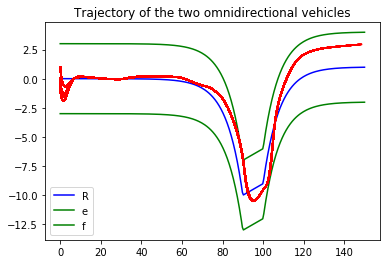

In [22]:
x0s = []
batch_size = 5
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 0.1 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.1 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.1 * (2 * random.random() - 1.0)])  # Initial state.

agent = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC', \
                      batch_size = 1000, \
                      checkpoint = 'checkpoints/mlp_temp_H2.pt')
'''
# Run MPSC guided controller and generate safe trajectory
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)
draw_agent_traj(traj)
draw_str(nn_traj, mpc_traj)

# Collect training trajectory
train_traj_aggr = [i for i in train_traj[:]] * 100
itr = 0

while itr < 1:
    train_traj = train_temp(agent, x0s, train_traj_aggr, paths = None)
    train_traj_aggr = train_traj_aggr + [i for i in train_traj[:]] * 100
    itr += 1
'''

agent_traj = agent_run(agent, x0s) 
print("Done. {} paths".format(len(agent_traj)))
draw_agent_traj(agent_traj)


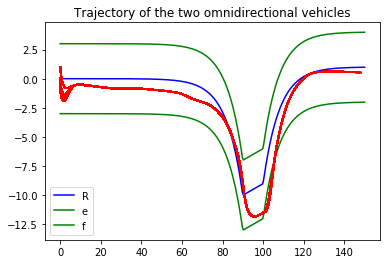

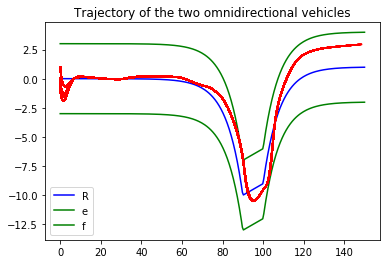

>>>>>>>>>>>>>>>>>>>>
Start epoch 0
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


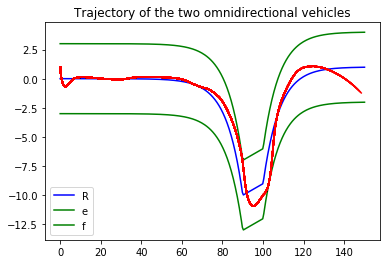

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


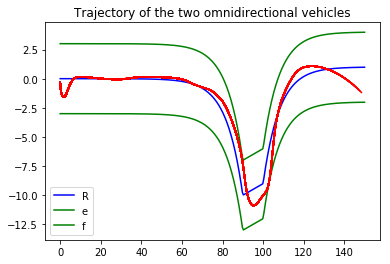

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


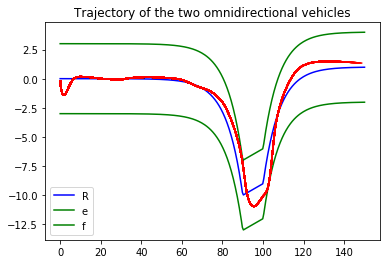

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


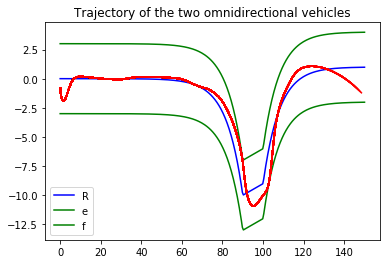

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


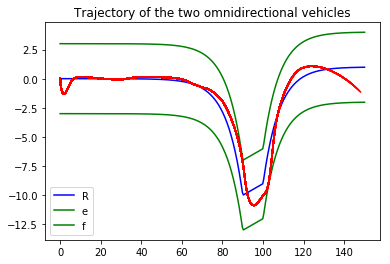

5
1453
[Epoch 1] avg_loss: 0.022
[Epoch 51] avg_loss: 0.005
Finished Training


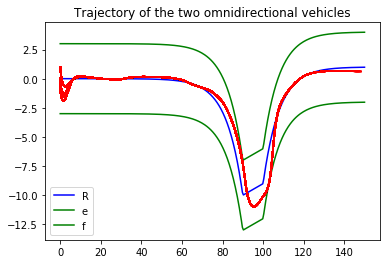

>>>>>Step 0 at [0.09707804703650993, 0.9621439829144143, 9.951611032290455, -1.2230035556791863]
Utilize NN output [[0.12098371 0.658998  ]]
>>>>>Step 1 at [ 0.26671652  0.49421345  9.95763088 -0.93555316]
Utilize NN output [[0.08283324 0.524807  ]]
>>>>>Step 2 at [ 0.56220741  0.09337178  9.96176309 -0.69587223]
Utilize NN output [[0.11691646 0.46140325]]
>>>>>Step 3 at [ 0.94459916 -0.22602344  9.96758242 -0.48108306]
Utilize NN output [[0.08323303 0.39158323]]
>>>>>Step 4 at [ 1.38650142 -0.45669121  9.97173449 -0.29532504]
Utilize NN output [[0.09823812 0.3322673 ]]
>>>>>Step 5 at [ 1.86362022 -0.60184092  9.97663066 -0.13549978]
Utilize NN output [[0.10775241 0.2664022 ]]
>>>>>Step 6 at [ 2.35801238e+00 -6.69243969e-01  9.98199752e+00 -5.66694337e-03]
Utilize NN output [[0.11250835 0.19931854]]
>>>>>Step 7 at [ 2.85724429 -0.67207312  9.98759932  0.09251615]
Utilize NN output [[0.11392313 0.13502617]]
>>>>>Step 8 at [ 3.3546298  -0.62592519  9.99327096  0.15953868]
Utilize NN outp

Utilize NN output [[0.09533436 0.01417406]]
>>>>>Step 128 at [ 6.55023004e+01 -5.24901291e-01  1.08393211e+01 -6.17646701e-02]
Utilize NN output [[ 0.17478916 -0.00111835]]
>>>>>Step 129 at [ 6.60434489e+01 -5.58367717e-01  1.08479726e+01 -6.23707757e-02]
Utilize NN output [[0.16271357 0.00213803]]
>>>>>Step 130 at [ 6.65849941e+01 -5.92188178e-01  1.08560373e+01 -6.12111128e-02]
Utilize NN output [[0.15162556 0.00400489]]
>>>>>Step 131 at [ 6.71269671e+01 -6.25404446e-01  1.08635610e+01 -5.90372632e-02]
Utilize NN output [[0.14136979 0.00471498]]
>>>>>Step 132 at [ 6.76693741e+01 -6.57463924e-01  1.08705827e+01 -5.64762109e-02]
Utilize NN output [[0.13183025 0.00450106]]
>>>>>Step 133 at [ 6.82122002e+01 -6.88153323e-01  1.08771363e+01 -5.40297706e-02]
Utilize NN output [[0.12292116 0.00358716]]
>>>>>Step 134 at [ 6.87554161e+01 -7.17531743e-01  1.08832516e+01 -5.20788797e-02]
Utilize NN output [[0.11458329 0.00217704]]
>>>>>Step 135 at [ 6.92989833e+01 -7.45865736e-01  1.08889558e+01

Utilize NN output [[ 0.02285102 -0.01466775]]
>>>>>Step 228 at [113.98013999  -0.69473171  11.25160859   0.19231381]
Utilize NN output [[ 0.02078756 -0.01397154]]
>>>>>Step 229 at [114.53237454  -0.58720043  11.25264781   0.18445421]
Utilize NN output [[ 0.04089269 -0.01548695]]
>>>>>Step 230 at [115.08551294  -0.48399864  11.25469131   0.17574144]
Utilize NN output [[ 0.037053  -0.0162531]]
>>>>>Step 231 at [115.63962539  -0.38560305  11.25654311   0.16659607]
Utilize NN output [[ 0.03353575 -0.0167705 ]]
>>>>>Step 232 at [116.19470149  -0.29226444  11.25821927   0.15715806]
Utilize NN output [[ 0.03032036 -0.01700063]]
>>>>>Step 233 at [116.7507126   -0.20415623  11.25973483   0.14758913]
Utilize NN output [[ 0.02738589 -0.01693562]]
>>>>>Step 234 at [117.30761267  -0.1213618   11.26110378   0.13805552]
Utilize NN output [[ 0.02471363 -0.01659871]]
>>>>>Step 235 at [ 1.17865341e+02 -4.38713589e-02  1.12623392e+01  1.28710383e-01]
Utilize NN output [[ 0.0222853  -0.01601951]]
>>>>>Ste

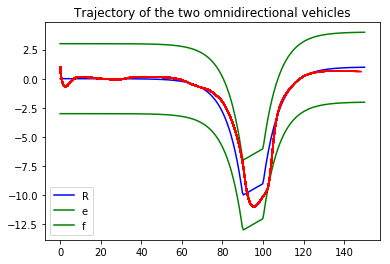

Intervention identified. Retrain agent in the pipeline.
1
290
[Epoch 1] avg_loss: 0.001
[Epoch 51] avg_loss: 0.001
Finished Training


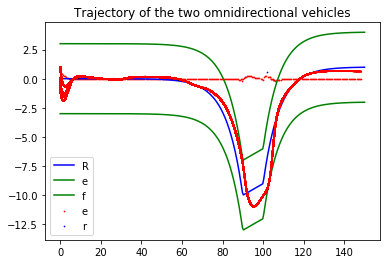

>>>>>Step 0 at [0.09707804703650993, 0.9621439829144143, 9.951611032290455, -1.2230035556791863]
Utilize NN output [[0.11999323 0.6587852 ]]
>>>>>Step 1 at [ 0.2667161   0.4942146   9.95758206 -0.93562371]
Utilize NN output [[0.08217832 0.524635  ]]
>>>>>Step 2 at [ 0.56217678  0.0933547   9.96168175 -0.69600973]
Utilize NN output [[0.11604242 0.46131596]]
>>>>>Step 3 at [ 0.94452066 -0.2260898   9.96745797 -0.48125772]
Utilize NN output [[0.08261997 0.39154398]]
>>>>>Step 4 at [ 1.38637643 -0.45683152  9.9715796  -0.29551886]
Utilize NN output [[0.09755213 0.3323083 ]]
>>>>>Step 5 at [ 1.86345888 -0.60207119  9.97644179 -0.13567775]
Utilize NN output [[0.10703397 0.26650795]]
>>>>>Step 6 at [ 2.35782879e+00 -6.69560830e-01  9.98177314e+00 -5.79820045e-03]
Utilize NN output [[0.11178505 0.19946498]]
>>>>>Step 7 at [ 2.85704821 -0.67245544  9.98733923  0.09245293]
Utilize NN output [[0.11321043 0.13518305]]
>>>>>Step 8 at [ 3.35442282 -0.62634023  9.99297569  0.15955066]
Utilize NN outp

Utilize NN output [[0.14548051 0.00457366]]
>>>>>Step 132 at [ 6.76672603e+01 -6.44672495e-01  1.08707891e+01 -5.55158316e-02]
Utilize NN output [[0.13564362 0.00431305]]
>>>>>Step 133 at [ 6.82101306e+01 -6.74841393e-01  1.08775299e+01 -5.31715346e-02]
Utilize NN output [[0.12646157 0.003377  ]]
>>>>>Step 134 at [ 6.87533955e+01 -7.03754873e-01  1.08838195e+01 -5.13348706e-02]
Utilize NN output [[0.11786762 0.00196179]]
>>>>>Step 135 at [ 6.92970160e+01 -7.31686103e-01  1.08896858e+01 -5.02672850e-02]
Utilize NN output [[0.10981617 0.00024282]]
>>>>>Step 136 at [ 6.98409491e+01 -7.59051195e-01  1.08951546e+01 -5.01350723e-02]
Utilize NN output [[ 0.10227224 -0.00164295]]
>>>>>Step 137 at [ 7.03851496e+01 -7.86357607e-01  1.09002505e+01 -5.10300803e-02]
Utilize NN output [[ 0.09534184 -0.0035743 ]]
>>>>>Step 138 at [ 7.09295713e+01 -8.14163632e-01  1.09050032e+01 -5.29781125e-02]
Utilize NN output [[ 0.08887818 -0.00547667]]
>>>>>Step 139 at [ 7.14741671e+01 -8.43042313e-01  1.09094354

Utilize NN output [[0.02312683 0.00038683]]
>>>>>Step 266 at [ 1.35275056e+02  6.60792127e-01  1.13009521e+01 -3.30978428e-03]
Utilize NN output [[0.02077298 0.00289534]]
>>>>>Step 267 at [ 1.35840126e+02  6.58921859e-01  1.13019906e+01 -1.67378413e-03]
Utilize NN output [[0.0186737  0.00447043]]
>>>>>Step 268 at [1.36405248e+02 6.57975966e-01 1.13029242e+01 8.52437123e-04]
Utilize NN output [[0.01679518 0.00525123]]
>>>>>Step 269 at [1.36970415e+02 6.58457735e-01 1.13037639e+01 3.82012401e-03]
Utilize NN output [[0.01510862 0.00540256]]
>>>>>Step 270 at [1.37535618e+02 6.60616891e-01 1.13045193e+01 6.87356000e-03]
Utilize NN output [[ 0.02960154 -0.01291734]]
>>>>>Step 271 at [ 1.38100868e+02  6.64502229e-01  1.13059989e+01 -4.27251875e-04]
Utilize NN output [[ 0.02645893 -0.00749581]]
>>>>>Step 272 at [ 1.38666201e+02  6.64260690e-01  1.13073215e+01 -4.66455181e-03]
Utilize NN output [[ 0.02369148 -0.00304442]]
>>>>>Step 273 at [ 1.39231591e+02  6.61623382e-01  1.13085059e+01 -6.3857

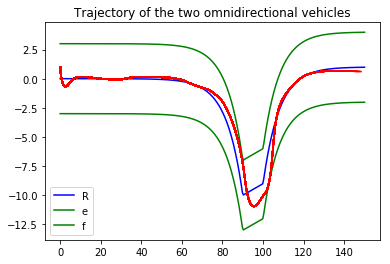

No intervention. Agent is clear.


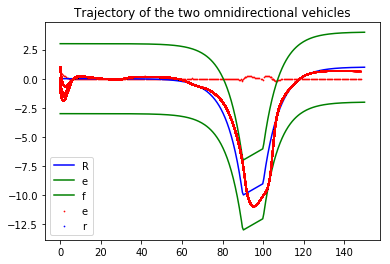

<<<<<<<<<<<<<<<<<<<<
Finished epoch 0




>>>>>>>>>>>>>>>>>>>>
Start epoch 1
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]
Found new optimal solution. Load QP parameters.


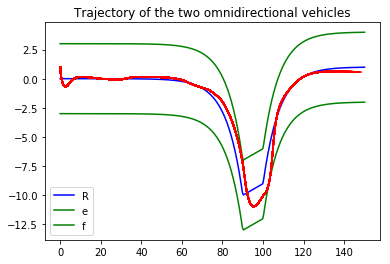

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


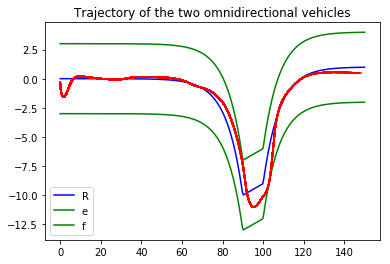

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


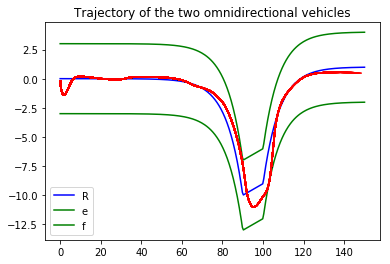

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


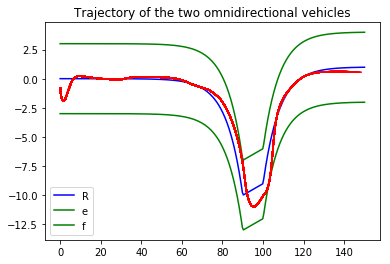

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


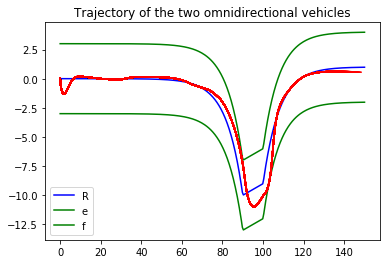

5
1449
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


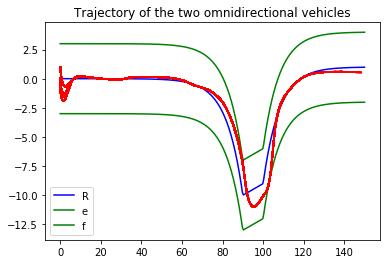

>>>>>Step 0 at [0.09707804703650993, 0.9621439829144143, 9.951611032290455, -1.2230035556791863]
Utilize NN output [[0.12011785 0.6593954 ]]
>>>>>Step 1 at [ 0.26671615  0.49421445  9.95758821 -0.93542145]
Utilize NN output [[0.08220299 0.52483463]]
>>>>>Step 2 at [ 0.56225811  0.09341406  9.96168912 -0.69573096]
Utilize NN output [[0.11602142 0.4613544 ]]
>>>>>Step 3 at [ 0.94469129 -0.22592407  9.9674643  -0.4809632 ]
Utilize NN output [[0.08259895 0.39152807]]
>>>>>Step 4 at [ 1.38661526 -0.45653578  9.97158488 -0.29523106]
Utilize NN output [[0.09751859 0.33226252]]
>>>>>Step 5 at [ 1.86373969 -0.60163821  9.97644542 -0.13541034]
Utilize NN output [[0.10699072 0.26642776]]
>>>>>Step 6 at [ 2.35812777e+00 -6.68995655e-01  9.98177463e+00 -5.56803397e-03]
Utilize NN output [[0.11173528 0.19936301]]
>>>>>Step 7 at [ 2.85734785 -0.67177536  9.98733826  0.0926342 ]
Utilize NN output [[0.11315791 0.13506967]]
>>>>>Step 8 at [ 3.35471398 -0.62557001  9.99297213  0.15967631]
Utilize NN outp

Utilize NN output [[0.14753084 0.00136873]]
>>>>>Step 132 at [ 6.76666938e+01 -6.52144007e-01  1.08668021e+01 -5.49136811e-02]
Utilize NN output [[0.13743362 0.00185406]]
>>>>>Step 133 at [ 6.82093854e+01 -6.81975189e-01  1.08736309e+01 -5.39062971e-02]
Utilize NN output [[0.12805656 0.00160906]]
>>>>>Step 134 at [ 6.87524362e+01 -7.11277434e-01  1.08799989e+01 -5.30314839e-02]
Utilize NN output [[0.11932222 0.00080416]]
>>>>>Step 135 at [ 6.92958196e+01 -7.40120906e-01  1.08859369e+01 -5.25940233e-02]
Utilize NN output [[ 0.1111663  -0.00039762]]
>>>>>Step 136 at [ 6.98395020e+01 -7.68741747e-01  1.08914724e+01 -5.28104480e-02]
Utilize NN output [[ 0.10354352 -0.00186735]]
>>>>>Step 137 at [ 7.03834452e+01 -7.97494365e-01  1.08966312e+01 -5.38273573e-02]
Utilize NN output [[ 0.09654819 -0.00348114]]
>>>>>Step 138 at [ 7.09276078e+01 -8.26813521e-01  1.09014437e+01 -5.57239822e-02]
Utilize NN output [[ 0.09003418 -0.00515161]]
>>>>>Step 139 at [ 7.14719460e+01 -8.57177648e-01  1.090593

Utilize NN output [[ 0.01919087 -0.01565281]]
>>>>>Step 237 at [1.19037225e+02 4.44696784e-02 1.12734185e+01 1.10493396e-01]
Utilize NN output [[ 0.03749223 -0.02457755]]
>>>>>Step 238 at [1.19597505e+02 1.06630105e-01 1.12752923e+01 9.66425316e-02]
Utilize NN output [[ 0.03359705 -0.02075487]]
>>>>>Step 239 at [1.20158680e+02 1.61033023e-01 1.12769715e+01 8.49433481e-02]
Utilize NN output [[ 0.03011434 -0.01707602]]
>>>>>Step 240 at [1.20720534e+02 2.08873826e-01 1.12784767e+01 7.53159916e-02]
Utilize NN output [[ 0.02700634 -0.01371482]]
>>>>>Step 241 at [1.21282892e+02 2.51308705e-01 1.12798267e+01 6.75823598e-02]
Utilize NN output [[ 0.02423323 -0.01078761]]
>>>>>Step 242 at [1.21845626e+02 2.89397608e-01 1.12810382e+01 6.14984799e-02]
Utilize NN output [[ 0.02175736 -0.0083444 ]]
>>>>>Step 243 at [1.22408639e+02 3.24065752e-01 1.12821258e+01 5.67919161e-02]
Utilize NN output [[ 0.01954566 -0.00639579]]
>>>>>Step 244 at [1.22971860e+02 3.56086598e-01 1.12831030e+01 5.31840603e-02]


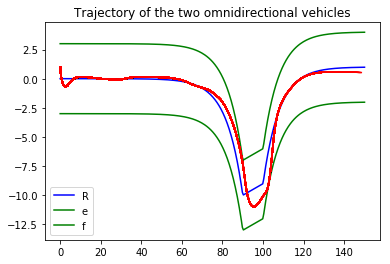

Intervention identified. Retrain agent in the pipeline.
1
290
[Epoch 1] avg_loss: 0.001
[Epoch 51] avg_loss: 0.001
Finished Training


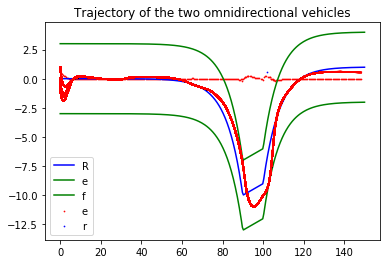

>>>>>Step 0 at [0.09707804703650993, 0.9621439829144143, 9.951611032290455, -1.2230035556791863]
Utilize NN output [[0.11889873 0.6588589 ]]
>>>>>Step 1 at [ 0.26671564  0.49421586  9.95752811 -0.93559928]
Utilize NN output [[0.08144012 0.5247352 ]]
>>>>>Step 2 at [ 0.56218397  0.0933661   9.96159114 -0.69594827]
Utilize NN output [[0.11508853 0.46145356]]
>>>>>Step 3 at [ 0.94454311 -0.22605124  9.96732029 -0.48114242]
Utilize NN output [[0.08194797 0.39161235]]
>>>>>Step 4 at [ 1.38641863 -0.45673845  9.97140854 -0.29537679]
Utilize NN output [[0.09679839 0.33231485]]
>>>>>Step 5 at [ 1.86351263 -0.60190758  9.9762334  -0.13553549]
Utilize NN output [[0.10624044 0.2664519 ]]
>>>>>Step 6 at [ 2.35788085e+00 -6.69325348e-01  9.98152553e+00 -5.68472030e-03]
Utilize NN output [[0.11098371 0.19935276]]
>>>>>Step 7 at [ 2.85708722 -0.67216323  9.98705204  0.09251014]
Utilize NN output [[0.11242056 0.1350302 ]]
>>>>>Step 8 at [ 3.35444392 -0.62602098  9.99264951  0.15953098]
Utilize NN outp

Utilize NN output [[0.15841661 0.00381828]]
>>>>>Step 131 at [ 6.71261967e+01 -6.18090250e-01  1.08671884e+01 -5.79799098e-02]
Utilize NN output [[0.1476678  0.00448167]]
>>>>>Step 132 at [ 6.76688260e+01 -6.49587152e-01  1.08745186e+01 -5.55447667e-02]
Utilize NN output [[0.13767244 0.00424764]]
>>>>>Step 133 at [ 6.82118841e+01 -6.79782248e-01  1.08813590e+01 -5.32352287e-02]
Utilize NN output [[0.12834112 0.00333618]]
>>>>>Step 134 at [ 6.87553406e+01 -7.08740641e-01  1.08877411e+01 -5.14201275e-02]
Utilize NN output [[0.11961094 0.00194314]]
>>>>>Step 135 at [ 6.92991568e+01 -7.36728407e-01  1.08936933e+01 -5.03623092e-02]
Utilize NN output [[0.1114374 0.0002408]]
>>>>>Step 136 at [ 6.98432894e+01 -7.64155374e-01  1.08992422e+01 -5.02311477e-02]
Utilize NN output [[ 0.10377605 -0.00163182]]
>>>>>Step 137 at [ 7.03876932e+01 -7.91524426e-01  1.09044124e+01 -5.11204295e-02]
Utilize NN output [[ 0.09670766 -0.00355478]]
>>>>>Step 138 at [ 7.09323219e+01 -8.19390358e-01  1.09092328e+01

Utilize NN output [[ 0.02821282 -0.00846956]]
>>>>>Step 263 at [1.33685323e+02 5.92704419e-01 1.13097362e+01 1.36943667e-03]
Utilize NN output [[ 0.02525731 -0.00400219]]
>>>>>Step 264 at [ 1.34250841e+02  5.93478860e-01  1.13109988e+01 -8.93738061e-04]
Utilize NN output [[ 0.02264234 -0.00052273]]
>>>>>Step 265 at [ 1.34816419e+02  5.92973381e-01  1.13121307e+01 -1.18936947e-03]
Utilize NN output [[0.02032217 0.00199073]]
>>>>>Step 266 at [ 1.35382051e+02  5.92300636e-01  1.13131467e+01 -6.33993782e-05]
Utilize NN output [[0.01825399 0.00362371]]
>>>>>Step 267 at [1.35947731e+02 5.92264773e-01 1.13140593e+01 1.98636874e-03]
Utilize NN output [[0.01640499 0.00450668]]
>>>>>Step 268 at [1.36513453e+02 5.93388507e-01 1.13148794e+01 4.53579170e-03]
Utilize NN output [[ 0.0320797 -0.0131808]]
>>>>>Step 269 at [ 1.37079231e+02  5.95954777e-01  1.13164829e+01 -2.92073661e-03]
Utilize NN output [[ 0.02865483 -0.00732641]]
>>>>>Step 270 at [ 1.37645089e+02  5.94302051e-01  1.13179152e+01 -7.06

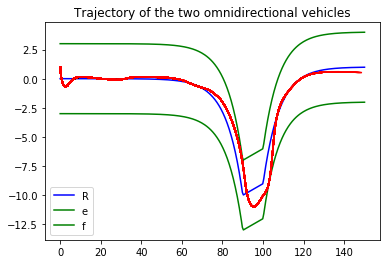

No intervention. Agent is clear.


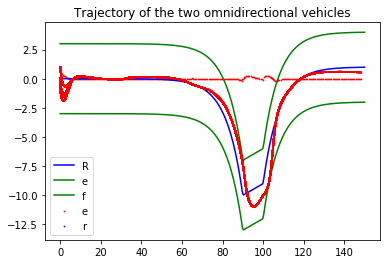

<<<<<<<<<<<<<<<<<<<<
Finished epoch 1




>>>>>>>>>>>>>>>>>>>>
Start epoch 2
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


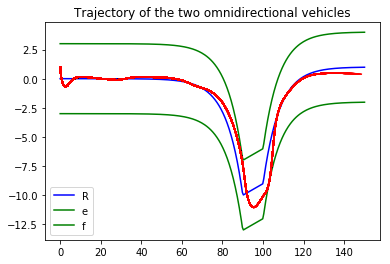

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


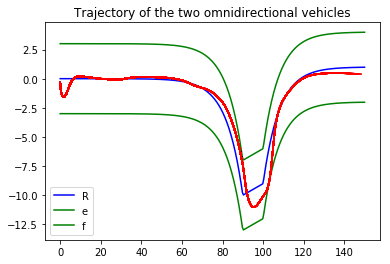

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


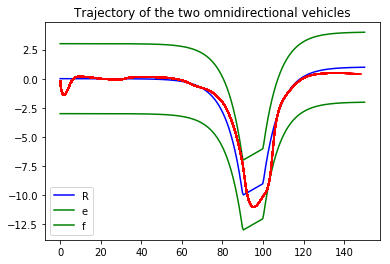

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


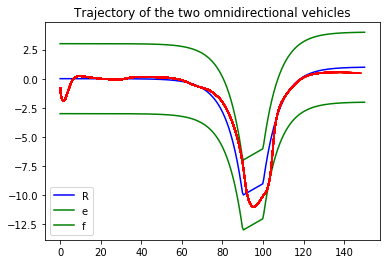

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


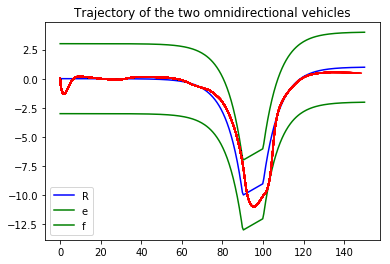

5
1449
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


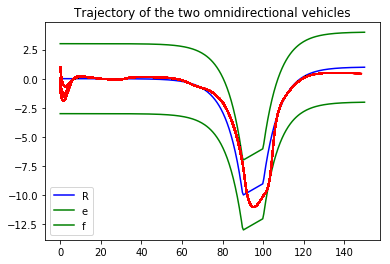

>>>>>Step 0 at [0.09707804703650993, 0.9621439829144143, 9.951611032290455, -1.2230035556791863]
Utilize NN output [[0.11908253 0.65960795]]
>>>>>Step 1 at [ 0.26671572  0.49421565  9.95753717 -0.93535102]
Utilize NN output [[0.08149463 0.52499866]]
>>>>>Step 2 at [ 0.56228386  0.09343883  9.96160291 -0.69559903]
Utilize NN output [[0.11509684 0.46151966]]
>>>>>Step 3 at [ 0.94475499 -0.22584534  9.96733247 -0.48076613]
Utilize NN output [[0.08194389 0.39161956]]
>>>>>Step 4 at [ 1.38671783 -0.45636653  9.97142052 -0.29499718]
Utilize NN output [[0.09678109 0.3322754 ]]
>>>>>Step 5 at [ 1.86386745 -0.60135471  9.97624452 -0.13517334]
Utilize NN output [[0.10621142 0.26635572]]
>>>>>Step 6 at [ 2.35826057e+00 -6.68593503e-01  9.98153521e+00 -5.36714065e-03]
Utilize NN output [[0.11094648 0.19922127]]
>>>>>Step 7 at [ 2.85746825 -0.67127285  9.98705989  0.09276473]
Utilize NN output [[0.11237808 0.13487701]]
>>>>>Step 8 at [ 3.35481353 -0.62500395  9.99265526  0.15971051]
Utilize NN outp

Utilize NN output [[0.16978396 0.00220717]]
>>>>>Step 130 at [ 6.65836716e+01 -6.06997107e-01  1.08591155e+01 -6.16194666e-02]
Utilize NN output [[0.15820947 0.00407156]]
>>>>>Step 131 at [ 6.71257927e+01 -6.40444662e-01  1.08669606e+01 -5.94088040e-02]
Utilize NN output [[0.14750296 0.00477583]]
>>>>>Step 132 at [ 6.76683649e+01 -6.72716202e-01  1.08742828e+01 -5.68138856e-02]
Utilize NN output [[0.1375427  0.00455667]]
>>>>>Step 133 at [ 6.82113723e+01 -7.03599801e-01  1.08811169e+01 -5.43363774e-02]
Utilize NN output [[0.12824117 0.00363836]]
>>>>>Step 134 at [ 6.87547844e+01 -7.33155939e-01  1.08874940e+01 -5.23569174e-02]
Utilize NN output [[0.11953764 0.00222389]]
>>>>>Step 135 at [ 6.92985616e+01 -7.61652483e-01  1.08934426e+01 -5.11462898e-02]
Utilize NN output [[0.11138212 0.00048806]]
>>>>>Step 136 at [ 6.98426600e+01 -7.89505385e-01  1.08989888e+01 -5.08804584e-02]
Utilize NN output [[ 0.10373925 -0.00142144]]
>>>>>Step 137 at [ 7.03870332e+01 -8.17227272e-01  1.09041572e+01

Utilize NN output [[ 0.02233117 -0.01779033]]
>>>>>Step 235 at [117.98316599  -0.15948049  11.27883157   0.12802002]
Utilize NN output [[ 0.02011652 -0.01698115]]
>>>>>Step 236 at [ 1.18542518e+02 -8.74785050e-02  1.12798373e+01  1.18444569e-01]
Utilize NN output [[ 0.03926591 -0.02529003]]
>>>>>Step 237 at [ 1.19102607e+02 -2.08270205e-02  1.12817995e+01  1.04184239e-01]
Utilize NN output [[ 0.03518683 -0.02167563]]
>>>>>Step 238 at [1.19663682e+02 3.78405773e-02 1.12835582e+01 9.19591462e-02]
Utilize NN output [[ 0.03153404 -0.01812562]]
>>>>>Step 239 at [1.20225515e+02 8.96524232e-02 1.12851343e+01 8.17341917e-02]
Utilize NN output [[ 0.02827093 -0.01482621]]
>>>>>Step 240 at [1.20787923e+02 1.35723042e-01 1.12865475e+01 7.33690165e-02]
Utilize NN output [[ 0.02535793 -0.01190283]]
>>>>>Step 241 at [1.21350764e+02 1.77092373e-01 1.12878151e+01 6.66522421e-02]
Utilize NN output [[ 0.02275814 -0.00942374]]
>>>>>Step 242 at [1.21913930e+02 2.14684330e-01 1.12889528e+01 6.13337298e-02]


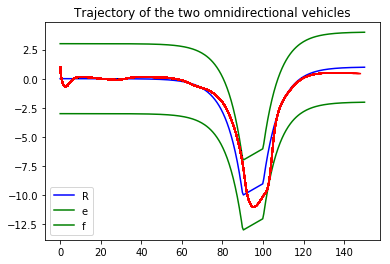

Intervention identified. Retrain agent in the pipeline.
1
289
[Epoch 1] avg_loss: 0.001
[Epoch 51] avg_loss: 0.001
Finished Training


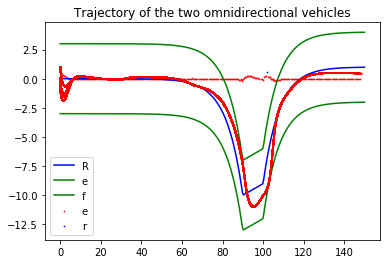

>>>>>Step 0 at [0.09707804703650993, 0.9621439829144143, 9.951611032290455, -1.2230035556791863]
Utilize NN output [[0.1178439 0.6590063]]
>>>>>Step 1 at [ 0.2667152   0.49421709  9.9574761  -0.93555041]
Utilize NN output [[0.08072502 0.5248687 ]]
>>>>>Step 2 at [ 0.56220105  0.09338457  9.96150361 -0.69584959]
Utilize NN output [[0.11415573 0.4616049 ]]
>>>>>Step 3 at [ 0.94458746 -0.22599149  9.96718673 -0.48098427]
Utilize NN output [[0.08128788 0.3916989 ]]
>>>>>Step 4 at [ 1.38649282 -0.45660534  9.9712422  -0.29518399]
Utilize NN output [[0.09605592 0.33232805]]
>>>>>Step 5 at [ 1.86360596 -0.6016798   9.97603028 -0.13533945]
Utilize NN output [[0.1054572  0.26638734]]
>>>>>Step 6 at [ 2.35797636e+00 -6.68999150e-01  9.98128367e+00 -5.52134100e-03]
Utilize NN output [[0.110191   0.19922203]]
>>>>>Step 7 at [ 2.85717012 -0.6717554   9.98677103  0.09260842]
Utilize NN output [[0.11163755 0.1348507 ]]
>>>>>Step 8 at [ 3.35450733 -0.62556566  9.99232984  0.15953936]
Utilize NN output

Utilize NN output [[0.1725124  0.00189993]]
>>>>>Step 130 at [ 6.65851146e+01 -5.95728258e-01  1.08627015e+01 -6.02661278e-02]
Utilize NN output [[0.16071002 0.00373475]]
>>>>>Step 131 at [ 6.71274625e+01 -6.28453092e-01  1.08706686e+01 -5.82376635e-02]
Utilize NN output [[0.14979567 0.0044384 ]]
>>>>>Step 132 at [ 6.76702600e+01 -6.60100136e-01  1.08781028e+01 -5.58252602e-02]
Utilize NN output [[0.13964677 0.00423694]]
>>>>>Step 133 at [ 6.82134910e+01 -6.90457691e-01  1.08850401e+01 -5.35207799e-02]
Utilize NN output [[0.13017552 0.00335078]]
>>>>>Step 134 at [ 6.87571253e+01 -7.19581234e-01  1.08915124e+01 -5.16971170e-02]
Utilize NN output [[0.12131885 0.00197443]]
>>>>>Step 135 at [ 6.93011240e+01 -7.47729483e-01  1.08975487e+01 -5.06218914e-02]
Utilize NN output [[0.11302409 0.00028214]]
>>>>>Step 136 at [ 6.98454440e+01 -7.75307549e-01  1.09031760e+01 -5.04681604e-02]
Utilize NN output [[ 0.10525408 -0.00158274]]
>>>>>Step 137 at [ 7.03900396e+01 -8.02815645e-01  1.09084194e+01

Utilize NN output [[ 0.02965366 -0.00857699]]
>>>>>Step 262 at [1.33185909e+02 5.02034277e-01 1.13183876e+01 1.70541257e-03]
Utilize NN output [[ 0.02653375 -0.0041023 ]]
>>>>>Step 263 at [ 1.33751860e+02  5.02999459e-01  1.13197140e+01 -6.16143586e-04]
Utilize NN output [[ 0.02377728 -0.00061902]]
>>>>>Step 264 at [ 1.34317876e+02  5.02650712e-01  1.13209026e+01 -9.66502261e-04]
Utilize NN output [[0.021331  0.0018985]]
>>>>>Step 265 at [1.34883947e+02 5.02103603e-01 1.13219690e+01 1.08130307e-04]
Utilize NN output [[0.0191524  0.00353749]]
>>>>>Step 266 at [1.35450070e+02 5.02164818e-01 1.13229265e+01 2.11069024e-03]
Utilize NN output [[0.01720393 0.00442451]]
>>>>>Step 267 at [1.36016236e+02 5.03359822e-01 1.13237866e+01 4.61559585e-03]
Utilize NN output [[ 0.03360783 -0.01326033]]
>>>>>Step 268 at [ 1.36582461e+02  5.05973308e-01  1.13254664e+01 -2.89182260e-03]
Utilize NN output [[ 0.03000559 -0.00739922]]
>>>>>Step 269 at [ 1.37148770e+02  5.04335639e-01  1.13269662e+01 -7.081724

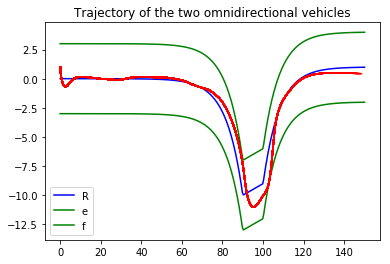

No intervention. Agent is clear.


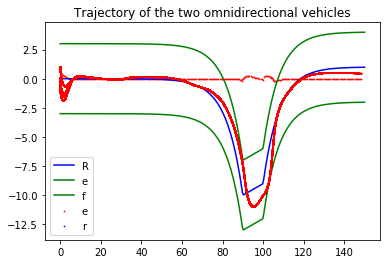

<<<<<<<<<<<<<<<<<<<<
Finished epoch 2




>>>>>>>>>>>>>>>>>>>>
Start epoch 3
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


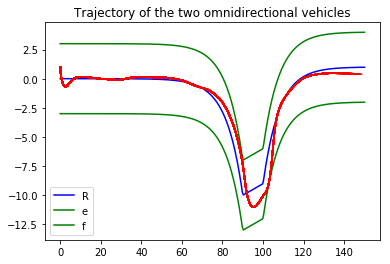

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


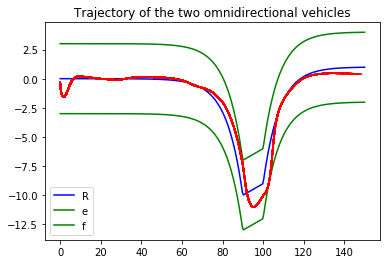

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


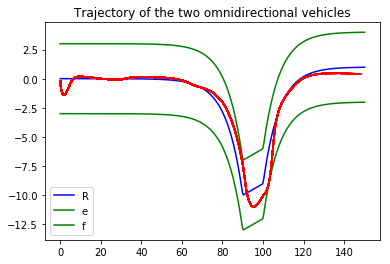

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


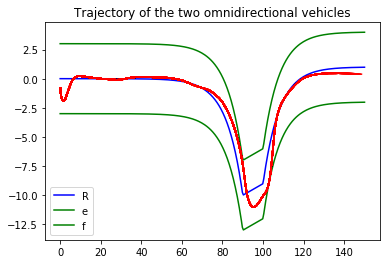

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


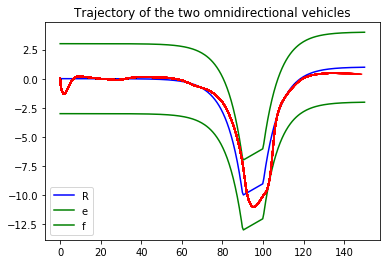

5
1449
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


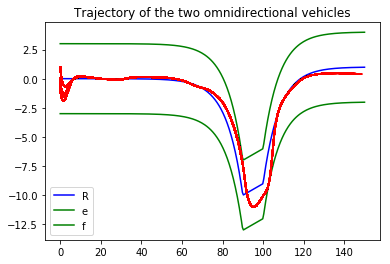

>>>>>Step 0 at [0.09707804703650993, 0.9621439829144143, 9.951611032290455, -1.2230035556791863]
Utilize NN output [[0.11792424 0.65933156]]
>>>>>Step 1 at [ 0.26671523  0.49421699  9.95748006 -0.9354426 ]
Utilize NN output [[0.08075293 0.5250016 ]]
>>>>>Step 2 at [ 0.56224443  0.09341615  9.96150896 -0.69569087]
Utilize NN output [[0.1141682  0.46165293]]
>>>>>Step 3 at [ 0.94468175 -0.2258994   9.96719269 -0.48080596]
Utilize NN output [[0.08129343 0.39171618]]
>>>>>Step 4 at [ 1.38662849 -0.45643459  9.97124844 -0.29499816]
Utilize NN output [[0.0960565  0.33231932]]
>>>>>Step 5 at [ 1.86376888 -0.60142048  9.97603654 -0.13515742]
Utilize NN output [[0.10545332 0.26634943]]
>>>>>Step 6 at [ 2.35815183e+00 -6.68649875e-01  9.98128975e+00 -5.35685855e-03]
Utilize NN output [[0.11018281 0.19916353]]
>>>>>Step 7 at [ 2.85734633 -0.67132401  9.98677671  0.0927449 ]
Utilize NN output [[0.1116263  0.13477947]]
>>>>>Step 8 at [ 3.35467751 -0.62506638  9.99233495  0.15964094]
Utilize NN outp

Utilize NN output [[ 0.18522017 -0.00124256]]
>>>>>Step 129 at [ 6.60430190e+01 -5.70233120e-01  1.08540423e+01 -6.19644639e-02]
Utilize NN output [[0.17239036 0.00198974]]
>>>>>Step 130 at [ 6.65848925e+01 -6.03853063e-01  1.08625774e+01 -6.08846281e-02]
Utilize NN output [[0.16060765 0.00385109]]
>>>>>Step 131 at [ 6.71272137e+01 -6.36912948e-01  1.08705395e+01 -5.87930007e-02]
Utilize NN output [[0.14971307 0.00456681]]
>>>>>Step 132 at [ 6.76699870e+01 -6.68861038e-01  1.08779697e+01 -5.63108340e-02]
Utilize NN output [[0.13957985 0.00436639]]
>>>>>Step 133 at [ 6.82131965e+01 -6.99481988e-01  1.08849037e+01 -5.39359750e-02]
Utilize NN output [[0.1301253 0.0034732]]
>>>>>Step 134 at [ 6.87568117e+01 -7.28830872e-01  1.08913735e+01 -5.20457098e-02]
Utilize NN output [[0.12127803 0.00208696]]
>>>>>Step 135 at [ 6.93007937e+01 -7.57168390e-01  1.08974079e+01 -5.09092201e-02]
Utilize NN output [[0.11299211 0.00038149]]
>>>>>Step 136 at [ 6.98450986e+01 -7.84902493e-01  1.09030335e+01 -

Utilize NN output [[ 0.03290912 -0.01398732]]
>>>>>Step 261 at [1.32623960e+02 4.65972430e-01 1.13167157e+01 6.29167251e-03]
Utilize NN output [[ 0.02939664 -0.00858057]]
>>>>>Step 262 at [1.33189821e+02 4.69532691e-01 1.13181851e+01 1.43659750e-03]
Utilize NN output [[ 0.02630487 -0.00410487]]
>>>>>Step 263 at [ 1.33755763e+02  4.70345721e-01  1.13195001e+01 -8.86371486e-04]
Utilize NN output [[ 0.02357253 -0.00061802]]
>>>>>Step 264 at [ 1.34321767e+02  4.69844031e-01  1.13206785e+01 -1.23615427e-03]
Utilize NN output [[0.0211476  0.00189956]]
>>>>>Step 265 at [ 1.34887827e+02  4.69144294e-01  1.13217357e+01 -1.60939906e-04]
Utilize NN output [[0.0189874  0.00354285]]
>>>>>Step 266 at [1.35453938e+02 4.69053184e-01 1.13226850e+01 1.84461110e-03]
Utilize NN output [[0.01705706 0.00442933]]
>>>>>Step 267 at [1.36020092e+02 4.70097520e-01 1.13235377e+01 4.35219229e-03]
Utilize NN output [[ 0.03332562 -0.01327119]]
>>>>>Step 268 at [ 1.36586305e+02  4.72561804e-01  1.13252034e+01 -3.1612

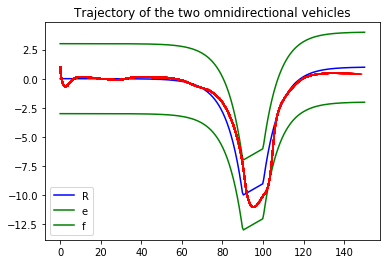

No intervention. Agent is clear.


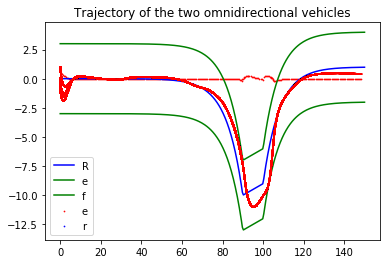

<<<<<<<<<<<<<<<<<<<<
Finished epoch 3




>>>>>>>>>>>>>>>>>>>>
Start epoch 4
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]
Converged.


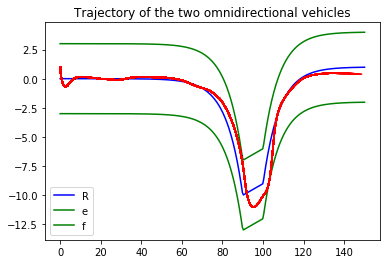

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]
Converged.


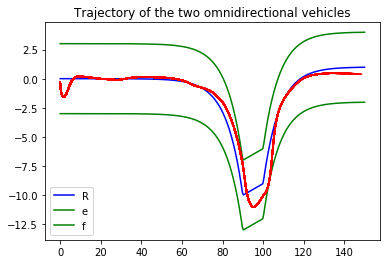

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]
Converged.


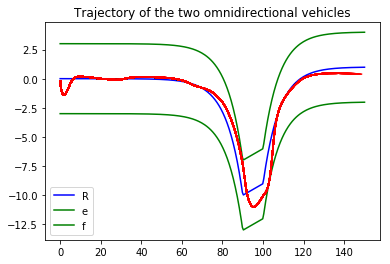

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]
Converged.


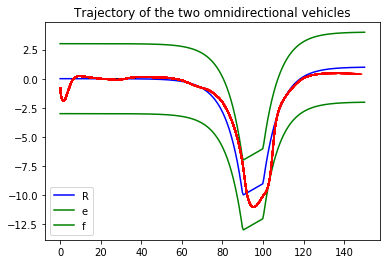

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 90 [Unsafe]
Converged.


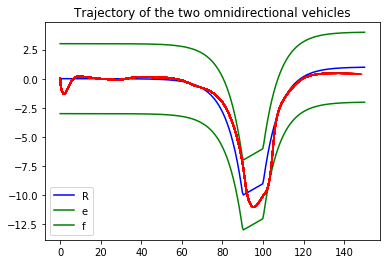

5
1449
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


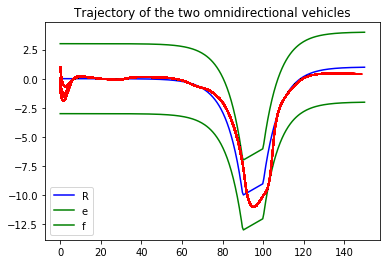

>>>>>Step 0 at [0.09707804703650993, 0.9621439829144143, 9.951611032290455, -1.2230035556791863]
Utilize NN output [[0.11792751 0.6593505 ]]
>>>>>Step 1 at [ 0.26671523  0.49421699  9.95748023 -0.93543632]
Utilize NN output [[0.08075387 0.5250093 ]]
>>>>>Step 2 at [ 0.56224696  0.09341799  9.96150916 -0.69568164]
Utilize NN output [[0.11416769 0.46165553]]
>>>>>Step 3 at [ 0.94468722 -0.22589404  9.96719288 -0.48079568]
Utilize NN output [[0.0812927  0.39171734]]
>>>>>Step 4 at [ 1.38663634 -0.45642468  9.97124858 -0.29498737]
Utilize NN output [[0.09605519 0.33231887]]
>>>>>Step 5 at [ 1.86377831 -0.60140543  9.97603662 -0.13514684]
Utilize NN output [[0.10545135 0.26634714]]
>>>>>Step 6 at [ 2.35816197e+00 -6.68629591e-01  9.98128973e+00 -5.34733904e-03]
Utilize NN output [[0.11018069 0.19916025]]
>>>>>Step 7 at [ 2.85735649 -0.67129898  9.98677658  0.09275284]
Utilize NN output [[0.11162429 0.13477634]]
>>>>>Step 8 at [ 3.35468729 -0.62503739  9.99233473  0.15964735]
Utilize NN outp

Utilize NN output [[0.10158627 0.01407492]]
>>>>>Step 128 at [ 6.55015544e+01 -5.37369235e-01  1.08448826e+01 -6.13280102e-02]
Utilize NN output [[ 0.18521376 -0.00124361]]
>>>>>Step 129 at [ 6.60430076e+01 -5.70617176e-01  1.08540388e+01 -6.20023517e-02]
Utilize NN output [[0.17238371 0.0019925 ]]
>>>>>Step 130 at [ 6.65848797e+01 -6.04257638e-01  1.08625736e+01 -6.09210202e-02]
Utilize NN output [[0.16060482 0.00385608]]
>>>>>Step 131 at [ 6.71271995e+01 -6.37337247e-01  1.08705355e+01 -5.88266824e-02]
Utilize NN output [[0.1497096  0.00457168]]
>>>>>Step 132 at [ 6.76699715e+01 -6.69303607e-01  1.08779656e+01 -5.63418682e-02]
Utilize NN output [[0.13957734 0.00437463]]
>>>>>Step 133 at [ 6.82131798e+01 -6.99941403e-01  1.08848995e+01 -5.39625282e-02]
Utilize NN output [[0.13012116 0.00348144]]
>>>>>Step 134 at [ 6.87567941e+01 -7.29304710e-01  1.08913691e+01 -5.20677790e-02]
Utilize NN output [[0.1212765  0.00209311]]
>>>>>Step 135 at [ 6.93007752e+01 -7.57654221e-01  1.08974033e+01

Utilize NN output [[0.01871758 0.00316992]]
>>>>>Step 259 at [1.31492761e+02 4.49338117e-01 1.13142171e+01 1.22039881e-02]
Utilize NN output [[0.01682309 0.00351342]]
>>>>>Step 260 at [1.32058451e+02 4.56242131e-01 1.13150582e+01 1.41915590e-02]
Utilize NN output [[ 0.03289515 -0.0139888 ]]
>>>>>Step 261 at [1.32624188e+02 4.64271361e-01 1.13167024e+01 6.27787278e-03]
Utilize NN output [[ 0.02938437 -0.00858348]]
>>>>>Step 262 at [1.33190048e+02 4.67823809e-01 1.13181712e+01 1.42115946e-03]
Utilize NN output [[ 0.02629346 -0.00410616]]
>>>>>Step 263 at [ 1.33755989e+02  4.68628101e-01  1.13194855e+01 -9.02540294e-04]
Utilize NN output [[ 0.02356203 -0.00061705]]
>>>>>Step 264 at [ 1.34321993e+02  4.68117260e-01  1.13206634e+01 -1.25177444e-03]
Utilize NN output [[0.02113849 0.00190023]]
>>>>>Step 265 at [ 1.34888052e+02  4.67408682e-01  1.13217202e+01 -1.76181952e-04]
Utilize NN output [[0.01897968 0.00354221]]
>>>>>Step 266 at [1.35454162e+02 4.67308943e-01 1.13226691e+01 1.82900359e-

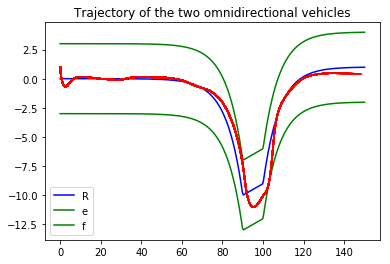

No intervention. Agent is clear.


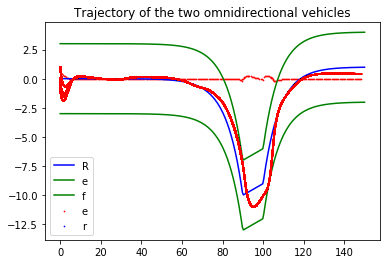

<<<<<<<<<<<<<<<<<<<<
Finished epoch 4






In [23]:
def QP(P_qp, q_qp, G_qp, h_qp, A_qp = None, b_qp = None):
    P_qp = numpy_sparse_to_spmatrix(P_qp)
    q_qp = matrix(q_qp)
    G_qp = numpy_sparse_to_spmatrix(G_qp)
    h_qp = matrix(h_qp)
    print("Starting solving QP")
    solvers.options['feastol'] = 1e-5
    sol=solvers.qp(P_qp, q_qp, G_qp, h_qp, A_qp, b_qp)
    #sol = {'x': [0.0 for i in range(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))]}
    theta_diffs = list(sol['x'])
    if theta_diffs is None:
        theta_diffs = np.zeros(agent.num_parameters(agent.model))
    return theta_diffs


#x0s = x0s[:1]

#  # loop over the dataset multiple times 
agent_0 = NeuralNetwork(input_size = (n + 1) * dynamics.state_size, \
                      model_name = 'mlp_H2_MPSC_0', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_traj_0 = agent_run(agent_0, x0s)
draw_agent_traj(agent_traj_0)

agent = NeuralNetwork(input_size = (n + 1) * dynamics.state_size, \
                      model_name = 'mlp_H2_MPSC_1', \
                      batch_size = 1000, \
                      checkpoint = 'checkpoints/mlp_temp_H2.pt')
agent_traj = agent_run(agent, x0s)
draw_agent_traj(agent_traj)

data_trajs = agent_traj

num_epoch = 5
tol = 1e-5

for epoch in range(num_epoch):
    print(">>>>>>>>>>>>>>>>>>>>")
    print("Start epoch {}".format(epoch))
    # Initialize Q matrix 
    Q1 = []
    Qx = []
    Qu = []
    Qx_T = []
    Qu_T = []
    Qxx = []
    Quu = []
    Qux = []
    Qxu = []

    # Initialize K, k
    K = []
    k = []

    # Run the latest model and original model to get (pi_\theta - u^*)
    u_diffs = []
    # Run the latest model to get gradient on the input x   
    pix = []
    # Run the latest model to get gradient on \theta
    pitheta = []

    # Barrier 1st order and 2nd order
    b1 = []
    bx = []
    bx_T = []
    bxx = []

    xs_diff = []
    us_diff = []
        
    h_qp = []
    G_qp = []
    
    theta_diffs = np.zeros([len(data_trajs), agent.num_parameters(agent.model)])
    P_qp = np.eye(agent.num_parameters(agent.model))
    q_qp = np.zeros([agent.num_parameters(agent.model), 1])
    
    num_itr = 10
    
    for i_traj in range(len(data_trajs)):
        print("Optimize rajectory {}".format(i_traj))
        Q1.append(np.empty([len(data_trajs[i_traj]), 1, 1]))
        Qx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1])) 
        Qu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        Qx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size])) 
        Qu_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.action_size]))
        Qxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))
        Quu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.action_size]))
        Qux.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        Qxu.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))

        # Initialize K, k
        K.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        k.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        # Run the latest model and original model to get (pi_\theta - u^*)
        u_diffs.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        # Run the latest model to get gradient on the input x   
        pix.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))
        # Run the latest model to get gradient on \theta
        pitheta.append(np.empty([len(data_trajs[i_traj]), \
                                 agent.num_parameters(agent.model), dynamics.action_size]))

        # Barrier 1st order and 2nd order
        b1.append(np.empty([len(data_trajs[i_traj]), 1]))
        bx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        bx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size]))
        bxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))

        xs_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        us_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        h_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size, 1]))
        G_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size , \
                              agent.num_parameters(agent.model)]))
        
        data_traj_opt = data_trajs[i_traj][:]
        J_opt = float('inf')
        converged = False
        
        alphas = 0.9**(np.arange(num_itr)**2)
        mus = 1.1**(np.arange(num_itr)**2)
        
        for i_itr in range(num_itr**2):
            alpha = alphas[int(i_itr/num_itr)]
            mu = mus[int(i_itr%num_itr)] 
            
            data_traj = data_trajs[i_traj][:]
            x_new = np.reshape([i for i in data_traj[0][0][:4]], [dynamics.state_size, 1])
            
            data_traj_tmp = []
            xs = []
            us = []
            
            agent.optimizer.zero_grad()
            J_new = 0.0
            
            for i_xy in range(len(data_traj)):
                x_y = data_traj[i_xy]
                x = np.reshape([i for i in x_y[0][:dynamics.state_size]], [dynamics.state_size, 1])
                u = np.reshape([i for i in x_y[1][:]], [dynamics.action_size, 1])

                x_u = x - np.array([[0.0], [barrier_u(x[0, 0])[1]], [0.0], [0.0]])
                x_l = x - np.array([[0.0], [barrier_l(x[0, 0])[1]], [0.0], [0.0]])

                b1[i_traj][i_xy] = q1[0] * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) - q1[0]\
                        + q1[1] * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) - q1[1]
                bx[i_traj][i_xy] = q1[0] * q2[0]\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T + q1[1] * q2[1]\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T
                
                bx_T[i_traj][i_xy] = bx[i_traj][i_xy].T

                bxx[i_traj][i_xy] = q1[0] * q2[0]**2\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T * A[0]\
                    + q1[1] * q2[1]**2\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T * A[1]

                i = abs(int(x[0]/0.5))
                x_nn = []
                for j in [x[:, 0]] + x_nominal[i : i + H]:
                    for e in j:
                        x_nn.append(e)
                while len(x_nn) < 4 *(H + 1):
                    for e in x_nominal[-1]:
                        x_nn.append(e)

                x_nn = np.asarray(x_nn)
                x_input = torch.tensor([x_nn], requires_grad = True).float().to(agent.device)   
                u_output = agent.model(x_input)[0]
                
                for i in range(dynamics.action_size):
                    # Get gradient w.r.t input x[0:4] <<<< pix 
                    pix[i_traj][i_xy, :, i] = torch.autograd.grad(\
                    u_output[i], x_input, retain_graph = True)[0].cpu().numpy().T[0:dynamics.state_size, 0]

                    # Get gradient w.r.t model parameters theta <<<< g_theta
                    torch.autograd.backward(u_output[i], retain_graph = True)
                    j = 0
                    for theta in agent.model.parameters():
                        pitheta_ = theta.grad.data.flatten()
                        pitheta[i_traj][i_xy, j : j + pitheta_.size()[0], i] = pitheta_.cpu().numpy()
                        j += pitheta_.size()[0]    

                u_output = u_output.detach().cpu().numpy()
                u_output = np.reshape(u_output, [dynamics.action_size, 1])

                u_0 = agent_0.run([x_nn])[0]
                u_0 = np.reshape(u_0, [dynamics.action_size, 1])

                u_diffs[i_traj][i_xy] = u_output - u_0

                Q1[i_traj][i_xy] = 4 * b1[i_traj][i_xy]
                Qx[i_traj][i_xy] = -2 * pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy]) + \
                                    2 * bx[i_traj][i_xy]
                Qx_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T) + \
                                    2 * bx[i_traj][i_xy].T
                Qu[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy]
                Qu_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T

                Qxx[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(\
                                    u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T)) + 2 * bxx[i_traj][i_xy]
                Quu[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T) + \
                            mu * np.eye(Quu[i_traj][i_xy].shape[0])
                Qux[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T))
                Qxu[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(u_diffs[i_traj][i_xy].T)

                K[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qux[i_traj][i_xy])
                k[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qu[i_traj][i_xy])

                x_diff = x_new - x

                us_diff[i_traj][i_xy] = alpha * k[i_traj][i_xy] + K[i_traj][i_xy].dot(x_diff)
                xs_diff[i_traj][i_xy] = x_diff
                
                u_new = u_output + us_diff[i_traj][i_xy]
                u_new = u_new.flatten().tolist()
                x_new = x_new.flatten().tolist()
                
                data_traj_tmp.append([x_new, u_new])
                xs.append(x_new)
                us.append(u_new)

                if i_xy < len(data_traj) - 1:
                    x_new = dynamics.f(xs[-1], us[-1], i_xy)[0]
                    x_new = np.reshape(x_new, x.shape)

            
            if (np.squeeze((np.asarray(xs) - \
                np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - \
                           b[0,0] <= 0)).all() == True and \
               (np.squeeze((np.asarray(xs) - \
                np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - \
                           b[1,0] <= 0)).all() == True:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Safe]".format(i_itr))
                #draw_agent_traj([data_traj_tmp])
                
                # Calculate J_new
                
                '''
                # Option 1: Directly calculate the loss of the QP
                for i_xy in range(xs_diffs[i_traj].shape[0]):                    
                    J_new += np.sum(Q1[i_traj][i_xy] + \
                                    2 * xs_diff[i_traj][i_xy].T.dot(Qx[i_traj][i_xy]) + \
                                    2 * us_diff[i_traj][i_xy].T.dot(Qu[i_traj][i_xy]) + \
                                    2 * (xs_diff[i_traj][i_xy].T.dot(Qxu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]) + \
                                    (xs_diff[i_traj][i_xy].T.dot(Qxx[i_traj][i_xy])).dot(xs_diff[i_traj][i_xy]) + \
                                    (us_diff[i_traj][i_xy].T.dot(Quu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]))
                '''
                # Option 2: Calculate the loss of the original model on the new trajectory(s)
                #           The input to the original model should be rebuilt for every single state
                for i_xy in range(xs_diff[i_traj].shape[0]):
                    x = data_trajs[i_traj][i_xy][0]
                    u = data_trajs[i_traj][i_xy][1]
                    
                    x_ = np.asarray(x) + xs_diff[i_traj][i_xy].flatten()
                    i_ = abs(int(x[0]/0.5))
                    x_nn_ = []
                    for j_ in [x_] + x_nominal[i_ : i_ + H]:
                        for k_ in j_:
                            x_nn_.append(k_)
                    while len(x_nn_) < 4 *(H + 1):
                        for k_ in x_nominal[-1]:
                            x_nn_.append(k_)
                    u_ = np.asarray(u) + us_diff[i_traj][i_xy].flatten()
                    u_0 = agent_0.run([x_nn_])[0]
                    J_new += np.linalg.norm(np.asarray(u_) - np.asarray(u_0), ord = 2 )
                    
                
                if J_opt > J_new:
                    if np.abs((J_opt - J_new)/J_opt) < tol:
                        converged = True
                        print("Converged.")
                        break
                    print("Found new optimal solution. Load QP parameters.")
                    for i_xy in range(len(data_traj)):
                        h_i = (us_diff[i_traj][i_xy].T - xs_diff[i_traj][i_xy].T.dot(pix[i_traj][i_xy])).T
                        G_i = pitheta[i_traj][i_xy].T

                        for j in range(dynamics.action_size):
                            h_qp[i_traj][i_xy + j, :] = h_i[j, 0]
                            G_qp[i_traj][i_xy + j, :] = G_i[j, :]
                    J_opt = J_new
                    data_traj_opt = data_traj_tmp[:]
                    
                #alpha = 1.1 * (1.0 + 0.9**i_itr) * alpha 
                #mu = 0.9 * (1.0 - 0.9**i_itr) * mu
                
            else:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Unsafe]".format(i_itr))  
                #draw_agent_traj([data_traj_tmp])
                #alpha = 0.9 * (1 - 0.9**i_itr) * alpha
                #mu = 1.1 * (1 + 0.9**i_itr) * mu 
        
        data_trajs[i_traj] = data_traj_opt[:]
        draw_agent_traj([data_traj_opt])
    
    
    pickle.dump((G_qp, h_qp), open('linear_eq.p', 'wb'))
    '''
    # Update the model
    
    # Option 1
    # Solve the perturbations on the model parameters with minimal norm via QP
    # Each newly generated trajecotry corresponds to a perturbation
    # Use the average as the final result
    #for i_traj in range(len(theta_diffs)):  
    #    theta_diffs[i_traj] = np.asarray(QP(P_qp, q_qp, G_qp[i_traj], h_qp[i_traj]))
    #theta_diffs = np.mean(theta_diffs, axis = 0)
    
    # Option 2
    # Solve the perturbations on the model parameters with minimal norm via QP
    # All newly generated trajecotries are included in one constraint
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = np.asarray(QP(P_qp, q_qp, G_qp, h_qp))
    
    # Option 3
    # Solve the perturbation on the model parameters via one linear equation
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = linalg.cgs(G_qp.T.dot(G_qp), G_qp.T.dot(h_qp))[0]
    #theta_diffs = np.linalg.solve(G_qp.T.dot(G_qp) + np.eye(G_qp.shape[1]), G_qp.T.dot(h_qp))
    
    # Modify the model parameters by hand
    i = 0
    for theta in agent.model.parameters():
        theta.data += torch.FloatTensor(\
            np.reshape(theta_diffs[i: i + theta.data.numel()], theta.data.size())).to(agent.device)
        i += theta.data.numel()
    
    
    
    ''' 
    
    train_trajs = data_to_train(data_trajs)
    while True:
        num_interv = 0
        data_trajs, nn_trajs, mpc_trajs, train_trajs  = train_pipeline(agent, x0s, train_trajs, paths = None)
        for i_traj in range(len(mpc_trajs)):
            num_interv += len(mpc_trajs[i_traj])
        if num_interv == 0:
            print("No intervention. Agent is clear.")
            break
        print("Intervention identified. Retrain agent in the pipeline.") 
        train_trajs = data_to_train(data_trajs)
        
    data_trajs = agent_run(agent, x0s)
    draw_agent_traj(data_trajs)
    print("<<<<<<<<<<<<<<<<<<<<")
    print("Finished epoch {}\n\n\n\n".format(epoch))
        